<a href="https://colab.research.google.com/github/cjkreienkamp/wpolo-scoresheet-ocr/blob/main/train_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Configure Environment

**Note**: If you are running this in Colab, enable a GPU

> `Runtime`   →   `Change runtime type`   →   `Hardware Accelerator: GPU`

### 0.1 Imports

In [8]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
from tqdm import tqdm
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd
from PIL import Image
import csv
from torchvision.io import read_image
from timeit import default_timer as timer
import pathlib
from typing import Dict, List

### 0.2 Configure GPU

In [9]:
print(torch.__version__)   # this notebook requires torch >= 1.10.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.4.0+cu121


'cpu'

### 0.3 Data Structures

In [10]:
from torch.utils.data import Dataset

class RoboflowDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        self.classes = [];

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)
        return

## 1. Collect Data

### 1.1 Pull the data from an online repository

In [11]:
!rm -r train
!rm README*
!curl -L "https://app.roboflow.com/ds/M661DNgI8g?key=cGCjih57DA" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   907  100   907    0     0   4122      0 --:--:-- --:--:-- --:--:--  4141
100 1119k  100 1119k    0     0  1639k      0 --:--:-- --:--:-- --:--:-- 1639k
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: train/
  inflating: train/_classes.csv      
 extracting: train/log10_0_14_png.rf.37188c9a8e43092b0af46096ae26d78c.jpg  
 extracting: train/log10_0_19_png.rf.d29b91f7507faa3ea25f2c834cbdbb08.jpg  
 extracting: train/log10_0_24_png.rf.2dbd196d26c4586fb9551dc499462a89.jpg  
 extracting: train/log10_0_29_png.rf.83624c1eb151a1466297a782597570fe.jpg  
 extracting: train/log10_0_34_png.rf.989415e0212050cc33953630db8fdb5c.jpg  
 extracting: train/log10_0_39_png.rf.d3d1e73768f586ce4c406c0becbcbdf8.jpg  
 extracting: train/log10_0_44_png.rf.3594f4cc42af5e89086c2b8cf6e94807.j

### 1.2 Transform into dataset class

In [12]:
csv_file = '/content/train/_classes.csv'
csv_data = csv.DictReader(open(csv_file))

transform = transforms.Compose([
    transforms.Lambda((lambda x: x[:3])),
    #transforms.Resize((28, 28)),           # TEAM
    transforms.Resize((28, 73)),            # REMARKS
    transforms.Grayscale(num_output_channels=1)
])

data = []; targets = []
first_row = True
for row in csv_data:
    if first_row:
        classes = [c.strip() for c in row.keys()][1:]
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        first_row = False

    image_path = '/content/train/' + row['filename']
    image = torchvision.io.read_image(image_path).type(torch.float32)
    image = image / 255.
    data.append(transform(image))
    for c in classes:
        if int(row[' '+c]): targets.append(class_to_idx[c])

data = torch.stack(data)
targets = torch.tensor(targets)
dataset = RoboflowDataset(data, targets)
dataset.classes = classes
NUM_CLASSES = len(classes)

### 1.3 Visualize the data

image shape: torch.Size([867, 1, 28, 73])
label shape: torch.Size([867])
classes: ['30TO-30secondtimeout', 'E-ejection', 'G-goal', 'P-penalty', 'TO-timeout', 'YC-yellowcard', 'empty']


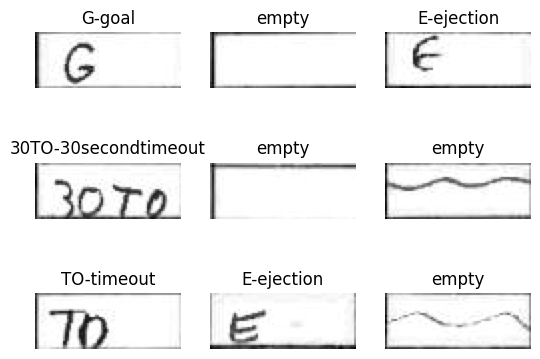

In [17]:
print('image shape:',dataset.data.shape)
print('label shape:',dataset.targets.shape)
print('classes:',dataset.classes)

random_sample = np.random.randint(0,dataset.data.shape[0],9)
for i , sample in zip(range(9), random_sample):
  image, label = dataset[sample]
  plt.subplot(3, 3, i + 1)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(classes[label])
  plt.axis("off")
plt.show()

## 2. Prepare Data

### 2.1 Convert data to tensors and resize

### 2.2 Split the dataset into train, test, and validation

* training set - used to train the model, compute the loss, and adjust the weights of the model using gradient descent

* validation set - used to evaluate the training model, adjust the hyperparameters, and pick the best version of the model

* test set - used as a final check of model predictions on new data to evaluate model performance

In [22]:
train, test = random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])
train, validate = random_split(train, [int(len(train)*0.75), len(train) - int(len(train)*0.75)])

print('samples in train dataset: ', len(train))
print('samples in validation dataset: ', len(validate))
print('samples in test dataset: ', len(test))

# want to display some stats on how many labels are in every dataset


samples in train dataset:  519
samples in validation dataset:  174
samples in test dataset:  174


### 2.3 Convert to dataloaders

In [24]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader = DataLoader(train, BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test, BATCH_SIZE, num_workers=NUM_WORKERS, shuffle = False)

img_custom, label_custom = next(iter(train_dataloader))
print(f"Dataloader image shape: {img_custom.shape} --> [batch_size, color_channels, height, width]")
print(f"Dataloader label shape: {label_custom.shape}")

DATALOADER_COLOR_CHANNELS = img_custom.shape[1]
DATALOADER_HEIGHT = img_custom.shape[2]
DATALOADER_WIDTH = img_custom.shape[3]

Creating DataLoader's with batch size 32 and 2 workers.
Dataloader image shape: torch.Size([32, 1, 28, 73]) --> [batch_size, color_channels, height, width]
Dataloader label shape: torch.Size([32])


## 3. Train Model

### 3.1 Build model

In [25]:
class TeamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(inplace=True)) #32*28*28
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32 --> 64
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(1)) #64*14*14
        self.res1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True)) #64*14*14
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(inplace=True)) #128*14*14
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(1)) #256*7*7
        self.res2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True)) #256*7*7
        self.classifier = nn.Sequential(nn.Flatten(),
                          nn.Linear(256*7*7, 1024),
                          nn.ReLU(),
                          nn.Linear(256*2, NUM_CLASSES)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = torch.flatten(out, start_dim=1)
        out = self.classifier(out)
        return out

    def training_step(self, batch):
        images, label = batch
        labels = torch.tensor([x-1 for x in label]).to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, label = batch
        labels = torch.tensor([x-1 for x in label]).to(device)
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        accuracy = torch.tensor(torch.sum(preds == labels).item() / len(preds))
        return {'val_loss': loss, 'val_acc': accuracy}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['train_loss'], result['val_acc']))

model = TeamModel()
model

TeamModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequ

### 3.2 Create train & test loop functions

In [32]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y); train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [33]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y); test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [34]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

### 3.2 Alternative

In [44]:
class TeamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(DATALOADER_COLOR_CHANNELS, 3, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 16, 5)
        #self.fc1 = nn.Linear(16*5*5, 120)          # TEAM
        self.fc1 = nn.Linear(1280, 120)             # REMARKS
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_0 = TeamModel().to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0

TeamModel(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1280, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 3.3 Train model

In [45]:
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
NUM_EPOCHS = 50

start_time = timer()
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [00:01<00:54,  1.12s/it]

Epoch: 1 | train_loss: 1.9463 | train_acc: 0.4057 | test_loss: 1.5297 | test_acc: 0.3631


  4%|▍         | 2/50 [00:01<00:30,  1.59it/s]

Epoch: 2 | train_loss: 1.5500 | train_acc: 0.3072 | test_loss: 1.4304 | test_acc: 0.3631


  6%|▌         | 3/50 [00:01<00:21,  2.17it/s]

Epoch: 3 | train_loss: 1.4850 | train_acc: 0.3201 | test_loss: 1.4268 | test_acc: 0.2478


  8%|▊         | 4/50 [00:01<00:17,  2.61it/s]

Epoch: 4 | train_loss: 1.4746 | train_acc: 0.3330 | test_loss: 1.3961 | test_acc: 0.3631


 10%|█         | 5/50 [00:02<00:15,  2.95it/s]

Epoch: 5 | train_loss: 1.4698 | train_acc: 0.3154 | test_loss: 1.4017 | test_acc: 0.2478


 12%|█▏        | 6/50 [00:02<00:13,  3.17it/s]

Epoch: 6 | train_loss: 1.4644 | train_acc: 0.3422 | test_loss: 1.3877 | test_acc: 0.2478


 14%|█▍        | 7/50 [00:02<00:12,  3.35it/s]

Epoch: 7 | train_loss: 1.4438 | train_acc: 0.3724 | test_loss: 1.3268 | test_acc: 0.5588


 16%|█▌        | 8/50 [00:02<00:12,  3.50it/s]

Epoch: 8 | train_loss: 1.3416 | train_acc: 0.4832 | test_loss: 1.1945 | test_acc: 0.5796


 18%|█▊        | 9/50 [00:03<00:13,  3.02it/s]

Epoch: 9 | train_loss: 1.1623 | train_acc: 0.5733 | test_loss: 1.0107 | test_acc: 0.5848


 20%|██        | 10/50 [00:03<00:15,  2.51it/s]

Epoch: 10 | train_loss: 1.0282 | train_acc: 0.5932 | test_loss: 0.8832 | test_acc: 0.6161


 22%|██▏       | 11/50 [00:04<00:15,  2.49it/s]

Epoch: 11 | train_loss: 0.8759 | train_acc: 0.6541 | test_loss: 0.8577 | test_acc: 0.6109


 24%|██▍       | 12/50 [00:04<00:15,  2.51it/s]

Epoch: 12 | train_loss: 0.8310 | train_acc: 0.6791 | test_loss: 0.7430 | test_acc: 0.7165


 26%|██▌       | 13/50 [00:05<00:14,  2.47it/s]

Epoch: 13 | train_loss: 0.7664 | train_acc: 0.7159 | test_loss: 0.6900 | test_acc: 0.7165


 28%|██▊       | 14/50 [00:05<00:14,  2.51it/s]

Epoch: 14 | train_loss: 0.7440 | train_acc: 0.7082 | test_loss: 0.6973 | test_acc: 0.7076


 30%|███       | 15/50 [00:05<00:13,  2.68it/s]

Epoch: 15 | train_loss: 0.7333 | train_acc: 0.6946 | test_loss: 0.7526 | test_acc: 0.6942


 32%|███▏      | 16/50 [00:06<00:11,  2.95it/s]

Epoch: 16 | train_loss: 0.6776 | train_acc: 0.7532 | test_loss: 0.6841 | test_acc: 0.7426


 34%|███▍      | 17/50 [00:06<00:10,  3.15it/s]

Epoch: 17 | train_loss: 0.7076 | train_acc: 0.7589 | test_loss: 0.6736 | test_acc: 0.7493


 36%|███▌      | 18/50 [00:06<00:09,  3.31it/s]

Epoch: 18 | train_loss: 0.5941 | train_acc: 0.7902 | test_loss: 0.5881 | test_acc: 0.8118


 38%|███▊      | 19/50 [00:06<00:08,  3.46it/s]

Epoch: 19 | train_loss: 0.5838 | train_acc: 0.8020 | test_loss: 0.5471 | test_acc: 0.8065


 40%|████      | 20/50 [00:07<00:08,  3.59it/s]

Epoch: 20 | train_loss: 0.5343 | train_acc: 0.8206 | test_loss: 0.5399 | test_acc: 0.8065


 42%|████▏     | 21/50 [00:07<00:08,  3.61it/s]

Epoch: 21 | train_loss: 0.4869 | train_acc: 0.8490 | test_loss: 0.5579 | test_acc: 0.8185


 44%|████▍     | 22/50 [00:07<00:07,  3.64it/s]

Epoch: 22 | train_loss: 0.5181 | train_acc: 0.8482 | test_loss: 0.5272 | test_acc: 0.8118


 46%|████▌     | 23/50 [00:08<00:07,  3.64it/s]

Epoch: 23 | train_loss: 0.5191 | train_acc: 0.8157 | test_loss: 0.7606 | test_acc: 0.7374


 48%|████▊     | 24/50 [00:08<00:07,  3.68it/s]

Epoch: 24 | train_loss: 0.5216 | train_acc: 0.8262 | test_loss: 0.4882 | test_acc: 0.8274


 50%|█████     | 25/50 [00:08<00:06,  3.70it/s]

Epoch: 25 | train_loss: 0.4546 | train_acc: 0.8564 | test_loss: 0.4815 | test_acc: 0.8326


 52%|█████▏    | 26/50 [00:08<00:06,  3.67it/s]

Epoch: 26 | train_loss: 0.4129 | train_acc: 0.8758 | test_loss: 0.4940 | test_acc: 0.8289


 54%|█████▍    | 27/50 [00:09<00:06,  3.72it/s]

Epoch: 27 | train_loss: 0.4082 | train_acc: 0.8703 | test_loss: 0.4962 | test_acc: 0.8118


 56%|█████▌    | 28/50 [00:09<00:05,  3.75it/s]

Epoch: 28 | train_loss: 0.3956 | train_acc: 0.8739 | test_loss: 0.4750 | test_acc: 0.8274


 58%|█████▊    | 29/50 [00:09<00:05,  3.67it/s]

Epoch: 29 | train_loss: 0.3935 | train_acc: 0.8860 | test_loss: 0.4943 | test_acc: 0.8549


 60%|██████    | 30/50 [00:09<00:05,  3.69it/s]

Epoch: 30 | train_loss: 0.3591 | train_acc: 0.8915 | test_loss: 0.4672 | test_acc: 0.8341


 62%|██████▏   | 31/50 [00:10<00:05,  3.76it/s]

Epoch: 31 | train_loss: 0.3328 | train_acc: 0.8897 | test_loss: 0.4718 | test_acc: 0.8274


 64%|██████▍   | 32/50 [00:10<00:04,  3.74it/s]

Epoch: 32 | train_loss: 0.3361 | train_acc: 0.8842 | test_loss: 0.4712 | test_acc: 0.8222


 66%|██████▌   | 33/50 [00:10<00:04,  3.71it/s]

Epoch: 33 | train_loss: 0.3185 | train_acc: 0.8813 | test_loss: 0.4623 | test_acc: 0.8512


 68%|██████▊   | 34/50 [00:10<00:04,  3.77it/s]

Epoch: 34 | train_loss: 0.3310 | train_acc: 0.8923 | test_loss: 0.6635 | test_acc: 0.7634


 70%|███████   | 35/50 [00:11<00:03,  3.77it/s]

Epoch: 35 | train_loss: 0.3641 | train_acc: 0.8640 | test_loss: 0.4917 | test_acc: 0.8222


 72%|███████▏  | 36/50 [00:11<00:03,  3.74it/s]

Epoch: 36 | train_loss: 0.3193 | train_acc: 0.8887 | test_loss: 0.4482 | test_acc: 0.8445


 74%|███████▍  | 37/50 [00:11<00:03,  3.65it/s]

Epoch: 37 | train_loss: 0.2915 | train_acc: 0.9173 | test_loss: 0.4364 | test_acc: 0.8534


 76%|███████▌  | 38/50 [00:12<00:03,  3.69it/s]

Epoch: 38 | train_loss: 0.3249 | train_acc: 0.8986 | test_loss: 0.4039 | test_acc: 0.8497


 78%|███████▊  | 39/50 [00:12<00:02,  3.75it/s]

Epoch: 39 | train_loss: 0.2819 | train_acc: 0.9099 | test_loss: 0.5095 | test_acc: 0.8013


 80%|████████  | 40/50 [00:12<00:02,  3.76it/s]

Epoch: 40 | train_loss: 0.2617 | train_acc: 0.9034 | test_loss: 0.4118 | test_acc: 0.8601


 82%|████████▏ | 41/50 [00:12<00:02,  3.72it/s]

Epoch: 41 | train_loss: 0.2468 | train_acc: 0.9283 | test_loss: 0.4116 | test_acc: 0.8549


 84%|████████▍ | 42/50 [00:13<00:02,  3.79it/s]

Epoch: 42 | train_loss: 0.2524 | train_acc: 0.9099 | test_loss: 0.4514 | test_acc: 0.8341


 86%|████████▌ | 43/50 [00:13<00:01,  3.83it/s]

Epoch: 43 | train_loss: 0.2973 | train_acc: 0.8700 | test_loss: 0.3846 | test_acc: 0.8497


 88%|████████▊ | 44/50 [00:13<00:01,  3.73it/s]

Epoch: 44 | train_loss: 0.2494 | train_acc: 0.9107 | test_loss: 0.4266 | test_acc: 0.8445


 90%|█████████ | 45/50 [00:13<00:01,  3.72it/s]

Epoch: 45 | train_loss: 0.2446 | train_acc: 0.9217 | test_loss: 0.3733 | test_acc: 0.8720


 92%|█████████▏| 46/50 [00:14<00:01,  3.77it/s]

Epoch: 46 | train_loss: 0.2325 | train_acc: 0.9181 | test_loss: 0.3877 | test_acc: 0.8653


 94%|█████████▍| 47/50 [00:14<00:00,  3.79it/s]

Epoch: 47 | train_loss: 0.1863 | train_acc: 0.9375 | test_loss: 0.3849 | test_acc: 0.8720


 96%|█████████▌| 48/50 [00:14<00:00,  3.72it/s]

Epoch: 48 | train_loss: 0.1974 | train_acc: 0.9338 | test_loss: 0.3555 | test_acc: 0.8616


 98%|█████████▊| 49/50 [00:14<00:00,  3.69it/s]

Epoch: 49 | train_loss: 0.1968 | train_acc: 0.9412 | test_loss: 0.3500 | test_acc: 0.8876


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]

Epoch: 50 | train_loss: 0.1723 | train_acc: 0.9485 | test_loss: 0.3456 | test_acc: 0.8876
Total training time: 15.240 seconds


## 4. Evaluate Model

### 4.0 Functions

In [46]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.title('Loss'); plt.xlabel('Epochs')
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy'); plt.xlabel('Epochs')
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.legend()

### 4.1 Plot loss and accuracy curves

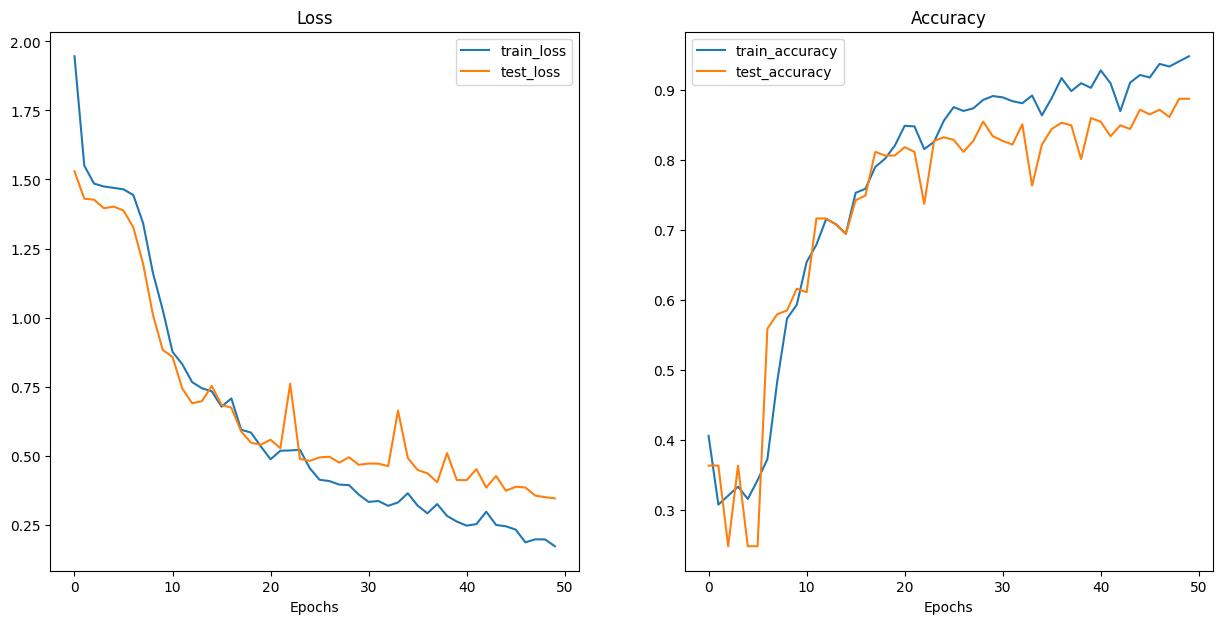

In [47]:
plot_loss_curves(model_0_results)

## 5. Predict

### 5.0 Functions

In [48]:
def pred_and_plot_image(model: torch.nn.Module,
                        image,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):

    #target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    #target_image = target_image / 255.

    if transform:
        target_image = transform(image)

    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0) # add an extra dimension to image
        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1) # convert logits --> prediction probabilities
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1) # convert prediction probabilities --> prediction labels

    plt.imshow(target_image.squeeze(), cmap='gray')
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

### 5.1 Predict and plot custom image

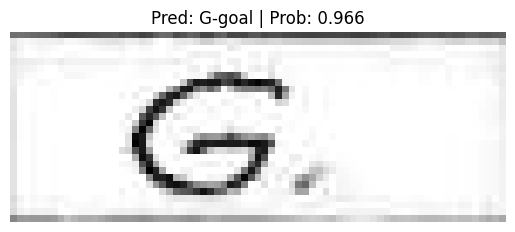

In [92]:
#custom_image_path = '/content/train/log10_1_13_png.rf.176317535a239d11565e2c35d557b700.jpg'
#print(custom_image_path)
#custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
#custom_image = custom_image / 255.
import random
image, label = random.choice(validate)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(classes[label])
plt.axis(False);

custom_image_transform = transforms.Compose([
    transforms.Lambda((lambda x: x[:3])),
    transforms.Resize((DATALOADER_HEIGHT, DATALOADER_WIDTH)),
    transforms.Grayscale(num_output_channels=1)
])

pred_and_plot_image(model=model_0,
                    image=image,
                    class_names=classes,
                    transform=custom_image_transform,
                    device=device)

### 5.2 Save model

In [93]:
save_model = torch.jit.script(model_0)
save_model.save('remarks_model.pt')